# Week 5: Monet painting - GAN model

DTSA 5511 - Intro to Deep Learning

Link to GitHub repo:

https://github.com/FleaBusyBeeBergs/dtsa5511-rnn.git <-- FIX LINK

## 1. Introduction - this needs work

This project was completed as part of the MSDS program at the University of Colorado at Boulder. It's purpose of this project is to generate images in the style of Monet, using a machine learning Cycle Generative Adversarial Network, or CycleGAN. A CycleGAN translates images from one domain into another.

uses two neural networks - one called a generator, the other a discriminator - to compete against each other. The generator creates images, in this case of a Monet painting, and the discriminator attempts to label the generated image as either a real Monet painting or a forgery. The discriminator is trained to recognize the style of a true Monet painting, and given proper training, should be able to recognize a formerly unseen real Monet work of art. 

In a nutshell, the generator model will take a real life photo image, which the discriminator labels as false. Having received the feedback, the generator then updates its model weights and creates a new image that is slightly closer to the true style of a Monet. After many iterations, the generator can come close to producing an image close to the style of Monet which the discriminator identifies as a true Monet.

CycleGAN: -cycle consistency loss, prevents G from doing wild stylistic changes that lose content, forces G to retain structure and composition while applying monet style.

# 1.1 The Data

I'm nothing of a painter myself: my drawn stick-people have 3 fingers, and I have the creativity of a potato. I thank WikiArt (1) for a brief introduction to Monet's artwork. Claude Monet (1840 - 1926) was a French Impressionist painter. Monet 'helped launch the artistic movement known as Impressionism.... famous for his landscapes of the French countryside, Monet espoused the idea that painters should represent their own perception of a subject rather than try to capture it with photographic realism.' His paintings were created with a large number of short but wide brush strokes, with a focus on how the paint was laid down on a canvas rather than the subject of the painting.



In [1]:
# restart session after running this cell
!pip install -q git+https://github.com/tensorflow/examples.git

  error: subprocess-exited-with-error
  
  × git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-4rhiiaxa did not run successfully.
  │ exit code: 128
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: subprocess-exited-with-error

× git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-4rhiiaxa did not run successfully.
│ exit code: 128
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


In [2]:
# general utilities
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore', category = FutureWarning)
from google.colab import files

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf

E0000 00:00:1750467463.608706      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750467463.701042      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


First, I loaded in the data. Info on TFRecord format can be found here (3). I used the TFrecords for this project.

In [3]:
monet_files = tf.io.gfile.glob('/kaggle/input/gan-getting-started/monet_tfrec/*.tfrec')
photo_files = tf.io.gfile.glob('/kaggle/input/gan-getting-started/photo_tfrec/*.tfrec')

print('monet tfrec length:' , len(monet_files))
print('photo tfrec length:' , len(photo_files))

monet tfrec length: 5
photo tfrec length: 20


TFRecords store information in a sequence of binary records (3). As the photo record count is 4x longer than the Monet record count, we have an indication that the photos contain a wider variety of content that the Monet files. This may require some balancing techniques when modelling.

The datasets from the Kaggle competition (2) contain images, all of the same 256x256 size:
* monet_tfrec, with 300 images of Monet paintings stored across 5 TFRecord files
* phote_tfrec, with 7,028 photo images stored across 20 TFRecord files
* monet_jpg, with 300 images of Monet painting in jpg format
* photo_jpg, with 7,028 photo images in jpg format.




## 2. EDA

Next, I had a look at a few of the images in both files.

In [4]:
# function to parse images
def decode_image(example_proto):
  feature_description = {
      'image': tf.io.FixedLenFeature([], tf.string),
       }

  example = tf.io.parse_single_example(example_proto, feature_description)

  image = tf.image.decode_jpeg(example['image'], channels = 3)
  image = tf.cast(image, tf.float32) / 255.0
  image = tf.image.resize(image, [256, 256])
  return image

In [5]:
# create dataset
monet_ds = tf.data.TFRecordDataset(monet_files).map(decode_image).batch(16)
photo_ds = tf.data.TFRecordDataset(photo_files).map(decode_image).batch(16)

### 2.1 Preview Images

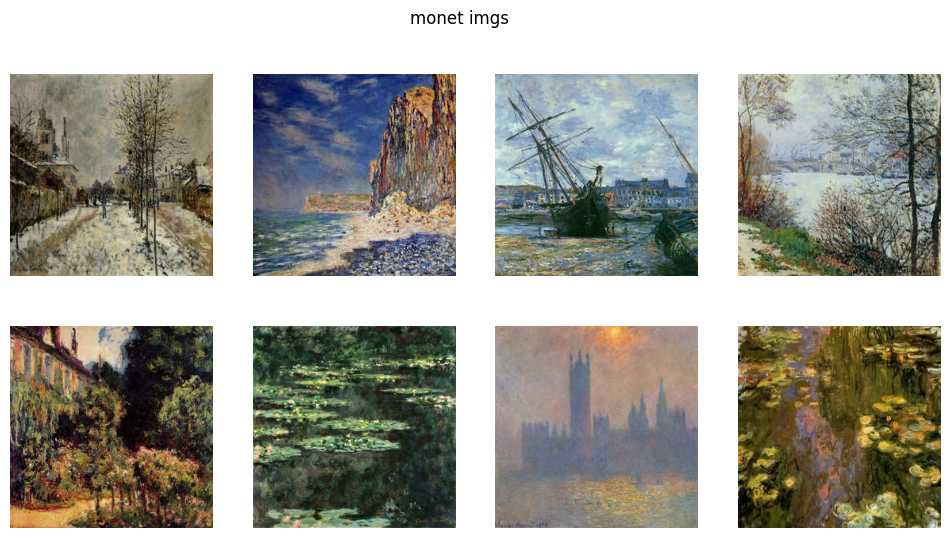

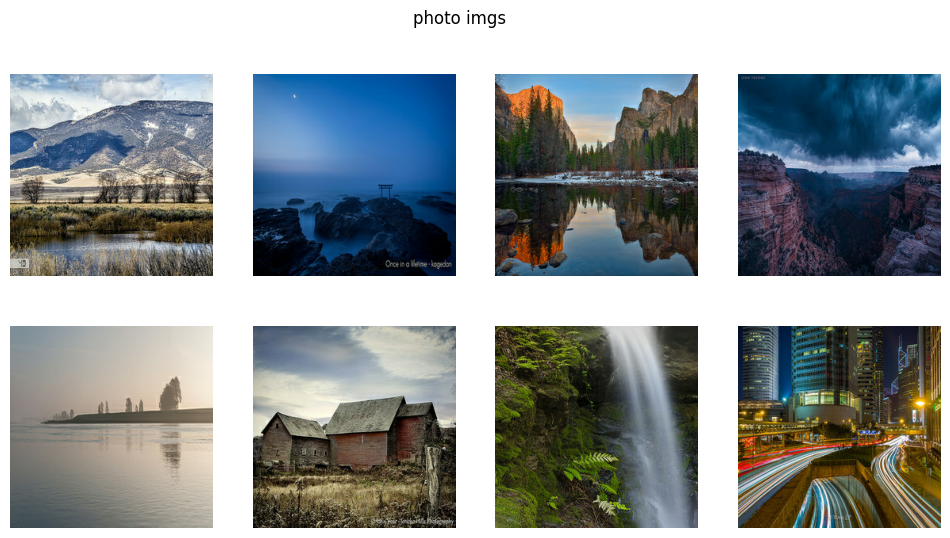

In [6]:
# preview images
def show_batch(dataset, title):
  plt.figure(figsize = (12, 6))
  for images in dataset.take(1):
    for i in range(8):
      ax = plt.subplot(2, 4, i+1)
      plt.imshow(images[i])
      plt.axis('off')
  plt.suptitle(title)
  plt.show()

show_batch(monet_ds, 'monet imgs')
show_batch(photo_ds, 'photo imgs')

My first impressions of the images (forgive my lack of 'art-y' words) are:
*  I see high contrast within the photos, whereas the paintings seem to have softer colour changes.
*  there are a lot of straight lines in the photos, whereas the paintings seem to have softer lines
* the photo images contain a lot of sections of solid colour while paintings do not. 
* the photos have larger patches of smooth fading colour whereas Monet's characteristic short brush strokes give the paintings a dappled (spotty?) look.


Next I took a look at some pixel value statistics to find what a machine can pick up from these images - I got these ideas <here> (4).

In [7]:
# list datasets to explore
datasets = [monet_ds, photo_ds]
dataset_names = ['monet', 'photo']

### 2.2 Contrast

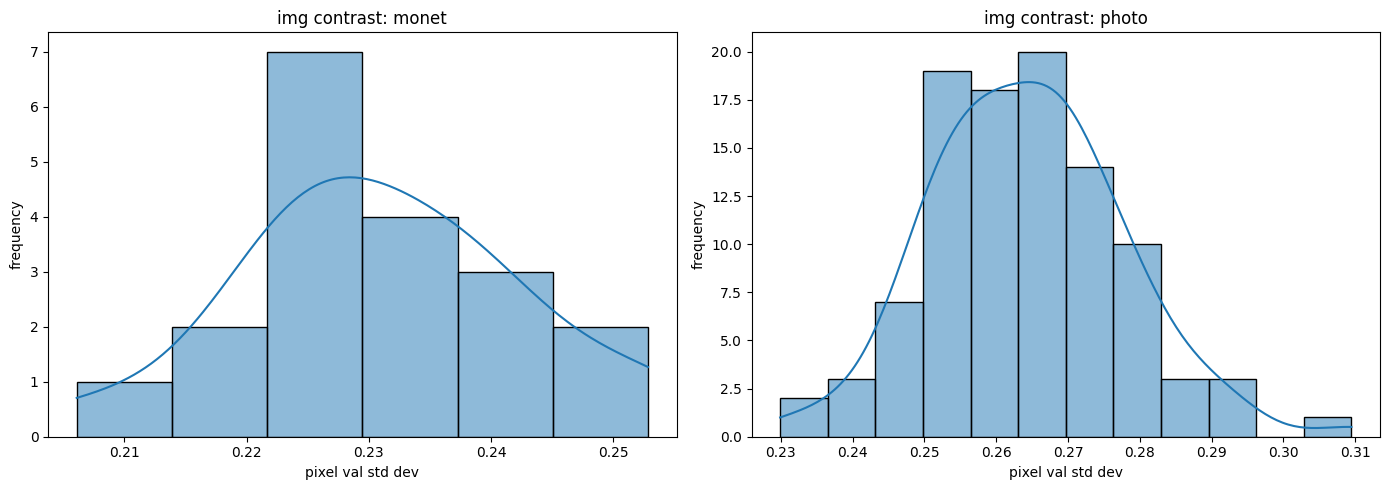



pixel value std deviation stats:

           monet      photo
count  19.000000  19.000000
mean    0.231086   0.263305
std     0.011645   0.016110
min     0.206098   0.229895
25%     0.223966   0.253948
50%     0.229229   0.267472
75%     0.238728   0.271275
max     0.252843   0.292147


In [8]:
# std dev of pixel values - contrast
contrast_data = {}

# grid layout
fig, axes = plt.subplots(1, 2, figsize = (14, 5))


# iterate through list for contrast
for idx, (dataset, name) in enumerate(zip(datasets, dataset_names)):
    contrasts = []
    for img in dataset.take(100):
        try:
            contrast = tf.math.reduce_std(img).numpy()
            contrasts.append(contrast)
        except:
            continue
    contrast_data[name] = contrasts 

    sns.histplot(contrasts,
                ax = axes[idx],
                kde = True)
    axes[idx].set_title(f'img contrast: {name}')
    axes[idx].set_xlabel('pixel val std dev')
    axes[idx].set_ylabel('frequency')
    

plt.tight_layout()
plt.show()

# stats to df
min_len = min(len(v) for v in contrast_data.values())
for key in contrast_data:
    contrast_data[key] = contrast_data[key][:min_len]

contrast_df = pd.DataFrame(contrast_data)
print('\n\npixel value std deviation stats:\n')
print(contrast_df.describe())

Contrast of an image can be measured with the standard deviation in the mean pixel values. From the above results, we can see that:
* the Monet paintings have a lower pixel value mean standard deviation than the photos do. This indicates that there is _lower average contrast in the paintings and higher average contrast in the photos_.
* the Monet paintings have a smaller std deviation of the std deviation of pixel values than the photos do. This indicates that there is _lower variation in contrast in the paintings and higher variation in contrast in the photos_.
* the minimum std deviation pixel value of the photos (0.2299) has nearly the same value as the mean pixel value std deviation of the Monet paintings (0.2311). This indicates that _the least contrasted photo image has about the same contrast as the average Monet Painting_
* Across the quartiles, Monet painting contrast values are consistently lower than the photo contrast values. This indicates that _lower (but more consistent)......_

### 2.3 Brightness

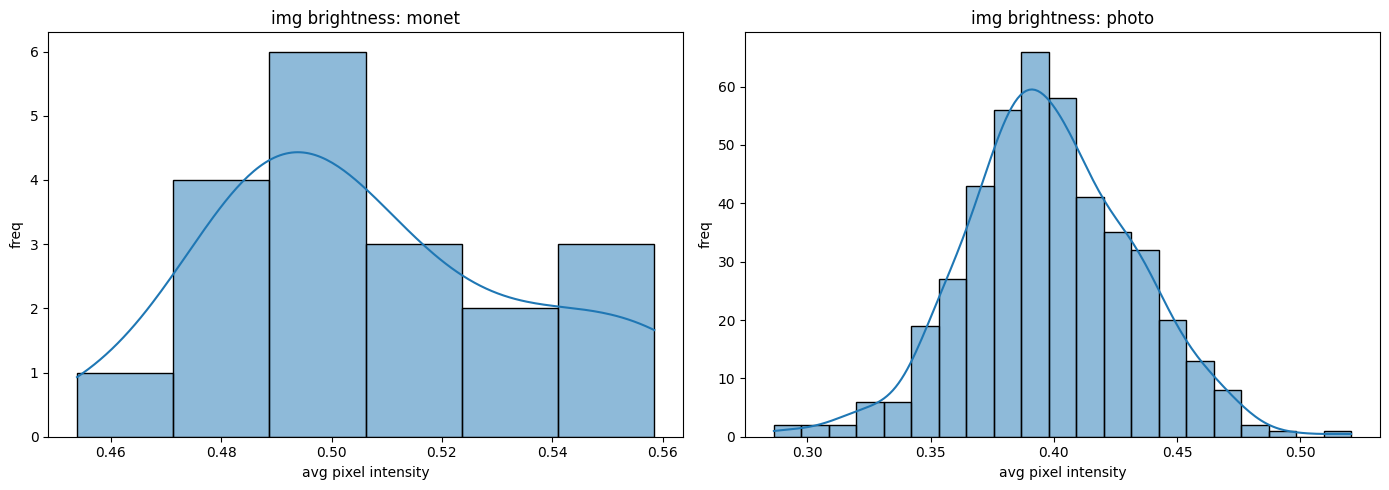



pixel brightness stats:

           monet      photo
count  19.000000  19.000000
mean    0.507532   0.390469
std     0.029536   0.030661
min     0.453874   0.327112
25%     0.488769   0.371852
50%     0.499101   0.383567
75%     0.527780   0.409706
max     0.558482   0.445587


In [9]:
# mean pixle value - brightness
brightness_data = {}

# grid layout
fig, axes = plt.subplots(1, 2, figsize=(14, 5)) 

# iterate throough list for mean density
for idx, (dataset, name) in enumerate(zip(datasets, dataset_names)):
    means = []
    for img in dataset.take(500):
        try:
            mean_val = tf.reduce_mean(img).numpy()
            means.append(mean_val)
        except:
            continue

    brightness_data[name] = means
    
    sns.histplot(means, 
                 ax = axes[idx], 
                 kde = True)
    axes[idx].set_title(f'img brightness: {name}')
    axes[idx].set_xlabel('avg pixel intensity')
    axes[idx].set_ylabel('freq')

plt.tight_layout()
plt.show()

# stats to df
min_len = min(len(v) for v in brightness_data.values())
for key in brightness_data:
    brightness_data[key] = brightness_data[key][:min_len]

brightness_df = pd.DataFrame(brightness_data)
print('\n\npixel brightness stats:\n')
print(brightness_df.describe())

Brightness of an image can be measured with the mean of the mean pixel values. From the above results, we can see that:

* the Monet paintings have a higher mean pixel value than the photos do. This indicates that there is _higher average brightness in the paintings and lowerr average brightness in the photos_.
* the Monet paintings have only a smaller std deviation of the mean pixel values than the photos do. This indicates that there is only _slightly less variation in the brightness of the paintings than in the photos_.
* the minimum mean pixel value of the paintings (0.4539) is higher than even the max mean pixel value of the photos (0.4456). This indicates that the _darkest of the paintings is brighter than the brightest photos_
* Across the quartiles, Monet painting brightness values are consistently higher than the photo brightness values. This indicates that _the paintings are brighter than the photos_

### 2.4 Colour distribution

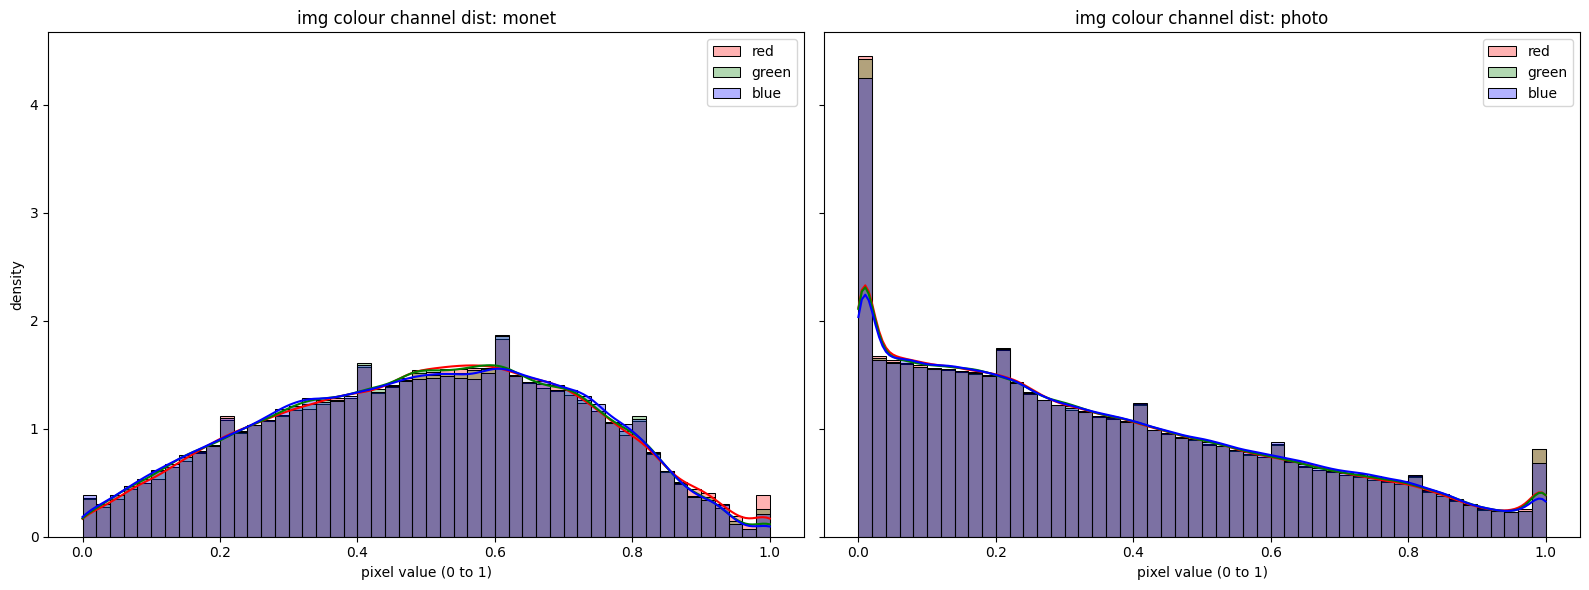

In [10]:
# colour channel dist
channel_stats = {}

# grid layout
fig, axes = plt.subplots(1, 
                         2, 
                         figsize = (16, 6), 
                         sharey = True)

# iterate through list for colour dist
for idx, (dataset, name) in enumerate(zip(datasets, dataset_names)):
    r_vals, g_vals, b_vals = [], [], []

    # colour channel vals
    for img in dataset.take(100):
        img_np = img.numpy()
        r_vals.extend(img_np[:, :, 0].flatten())
        g_vals.extend(img_np[:, :, 1].flatten())
        b_vals.extend(img_np[:, :, 2].flatten())

    channel_stats[name] = {}
    for channel_name, values in zip(['r', 'g', 'b'], [r_vals, g_vals, b_vals]):
        channel_stats[name][f'{channel_name}_mean'] = np.mean(values)
        channel_stats[name][f'{channel_name}_std']  = np.std(values)
        

    # histograms axis
    sns.histplot(r_vals, 
                 color = 'red', 
                 label = 'red', 
                 bins = 50, 
                 stat = 'density', 
                 kde = True, 
                 alpha = 0.3, 
                 ax = axes[idx])
    sns.histplot(g_vals, 
                 color = 'green', 
                 label = 'green', 
                 bins = 50, 
                 stat = 'density', 
                 kde = True, 
                 alpha = 0.3, 
                 ax = axes[idx])
    sns.histplot(b_vals, 
                 color = 'blue', 
                 label = 'blue', 
                 bins = 50, 
                 stat = 'density', 
                 kde = True, 
                 alpha = 0.3, 
                 ax = axes[idx])

    
    axes[idx].set_title(f'img colour channel dist: {name}')
    axes[idx].set_xlabel('pixel value (0 to 1)')
    axes[idx].set_ylabel('density')
    axes[idx].legend()

plt.tight_layout()
plt.show()

Looking at the distribution of the pixel colour channel values in the plots above, we can see that:
* Both the paintings and the photos have balanced RGB colours
* The distribution of the RGB channels in the paintings shows sort of a bell-shaped curve centered around approx. 0.5, but with no tails. This indicates that _the paintings are moderately coloured and few are very dark or very light_
    * I looked into what the distribution of colour within Monet's works meant - there was a lot of artsy talk about his use of light, which I won't get int here. The main point here is that _Monet used 'light' and colours differently than seen in real life photos_.
* The distribution of the RGB channels in the photos shows a downward linear trend, with a large spike at the dark end (0.0, or pure black) and a smaller spike at the light end (1.0, or pure white). This indicates that _the photos contain a lot of very dark images, and the presence of some very light photos_
    * Looking at the images of photos, even _I_ can see that _photos contain a lot of dark shadows and bright areas such as clouds, snow, and sunlight_ 

In [11]:

channel_stats_df = pd.DataFrame(channel_stats)
print('\n\ncolour channel stats:\n')
print(channel_stats_df.round(4))



colour channel stats:

         monet   photo
r_mean  0.5003  0.3446
r_std   0.2251  0.2675
g_mean  0.4955  0.3459
g_std   0.2239  0.2676
b_mean  0.4943  0.3470
b_std   0.2246  0.2659


The pixel colour distribution of an image can be measured by the red, green, and blue values of the pixels. From the results above, we can see that:
* The mean values for all three pixel colour channel values are similar with each of the painting and photo images, but overall the paintings have higher mean colour channel values than the photos. This indicates that _the colours are balance with each dataset, but overall the colours are brighter in the paintings_.
* The std deviation of the RGB colour channels in the paintings (~0.22) is lower than the std deviation of the RGB colour channels in the photos. This indicates that _the paintings have lower contrast within RGB channels than do the photos_


## 3 Modeling

To create a CycleGAN, I used a TensorFlow tutorial (5)


✅ Step 1: Prepare the Datasets
You've already done this, but here's the best practice version:

def decode_image(example_proto):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example_proto, feature_description)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.image.resize(image, [256, 256])
    image = tf.cast(image, tf.float32) / 255.0  # normalize to [0, 1]
    return image

# Load and prepare datasets
monet_ds = tf.data.TFRecordDataset(monet_files)\
    .map(decode_image, num_parallel_calls=tf.data.AUTOTUNE)\
    .cache()\
    .shuffle(1000)\
    .batch(1)

photo_ds = tf.data.TFRecordDataset(photo_files)\
    .map(decode_image, num_parallel_calls=tf.data.AUTOTUNE)\
    .cache()\
    .shuffle(1000)\
    .batch(1)

In [12]:
# batch size 1
monet_ds = tf.data.TFRecordDataset(monet_files).map(decode_image).batch(1)
photo_ds = tf.data.TFRecordDataset(photo_files).map(decode_image).batch(1)

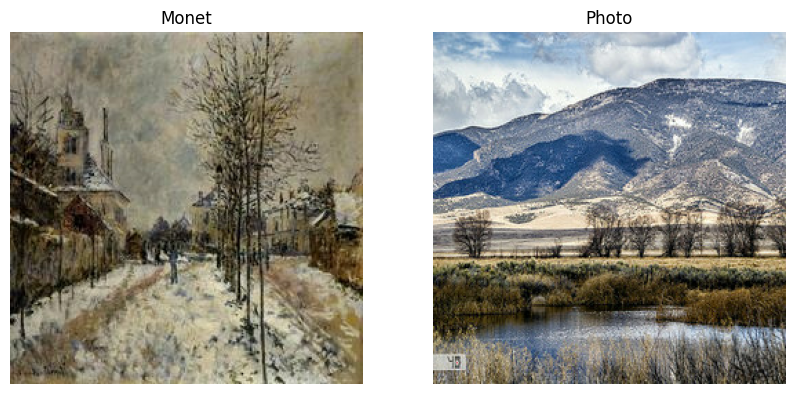

In [13]:
for monet_img, photo_img in zip(monet_ds.take(1), photo_ds.take(1)):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(monet_img[0])
    axes[0].set_title('Monet')
    axes[0].axis('off')
    
    axes[1].imshow(photo_img[0])
    axes[1].set_title('Photo')
    axes[1].axis('off')
    plt.show()

In [14]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                                      kernel_initializer=initializer, use_bias=False))
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
    result.add(tf.keras.layers.LeakyReLU())
    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                               kernel_initializer=initializer, use_bias=False))
    result.add(tf.keras.layers.BatchNormalization())
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    result.add(tf.keras.layers.ReLU())
    return result

def Generator():
    inputs = layers.Input(shape=[256, 256, 3])

    # Encoder / Downsampling
    down_stack = [
        downsample(64, 4, apply_batchnorm=False),  # (128, 128, 64)
        downsample(128, 4),                        # (64, 64, 128)
        downsample(256, 4),                        # (32, 32, 256)
        downsample(512, 4),                        # (16, 16, 512)
        downsample(512, 4),                        # (8, 8, 512)
        downsample(512, 4),                        # (4, 4, 512)
        downsample(512, 4),                        # (2, 2, 512)
        downsample(512, 4),                        # (1, 1, 512)
    ]

    # Decoder / Upsampling
    up_stack = [
        upsample(512, 4, apply_dropout=True),     # (2, 2, 1024)
        upsample(512, 4, apply_dropout=True),     # (4, 4, 1024)
        upsample(512, 4, apply_dropout=True),     # (8, 8, 1024)
        upsample(512, 4),                         # (16, 16, 1024)
        upsample(256, 4),                         # (32, 32, 512)
        upsample(128, 4),                         # (64, 64, 256)
        upsample(64, 4),                          # (128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(3, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh')  # (256, 256, 3)

    x = inputs
    skips = []

    # Downsample path
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])

    # Upsample path with skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

### 3.1 Generator models

### 3.2 Discriminator models

In [15]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                               kernel_initializer=initializer, use_bias=False))
    result.add(tf.keras.layers.BatchNormalization())
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    result.add(tf.keras.layers.ReLU())
    return result

### 3.3 Losses
* Adversarial loss (for realism)
* Cycle consistency loss (F(G(x)) ~ x)
* Identity loss (preserve colour/composition when style is not needed)

## References
1. https://www.masterclass.com/articles/monet-paintings-guide
2. https://www.kaggle.com/competitions/gan-getting-started/data
3. https://www.tensorflow.org/tutorials/load_data/tfrecord
4. https://towardsdatascience.com/exploratory-data-analysis-ideas-for-image-classification-d3fc6bbfb2d2/
5. https://www.tensorflow.org/tutorials/generative/cyclegan